In [46]:
#libraries
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn import metrics
from keras.models import Model
from keras import regularizers
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import joblib 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import IsolationForest

In [2]:
# importing DataSet
df1 = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df2 = pd.read_csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df3 = pd.read_csv("Friday-WorkingHours-Morning.pcap_ISCX.csv")
df4 = pd.read_csv("Monday-WorkingHours.pcap_ISCX.csv")
df5 = pd.read_csv("Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df6 = pd.read_csv("Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df7 = pd.read_csv("Tuesday-WorkingHours.pcap_ISCX.csv")
df8 = pd.read_csv("Wednesday-workingHours.pcap_ISCX.csv")

In [3]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8])
del df1, df2, df3, df4, df5, df6, df7, df8

In [4]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


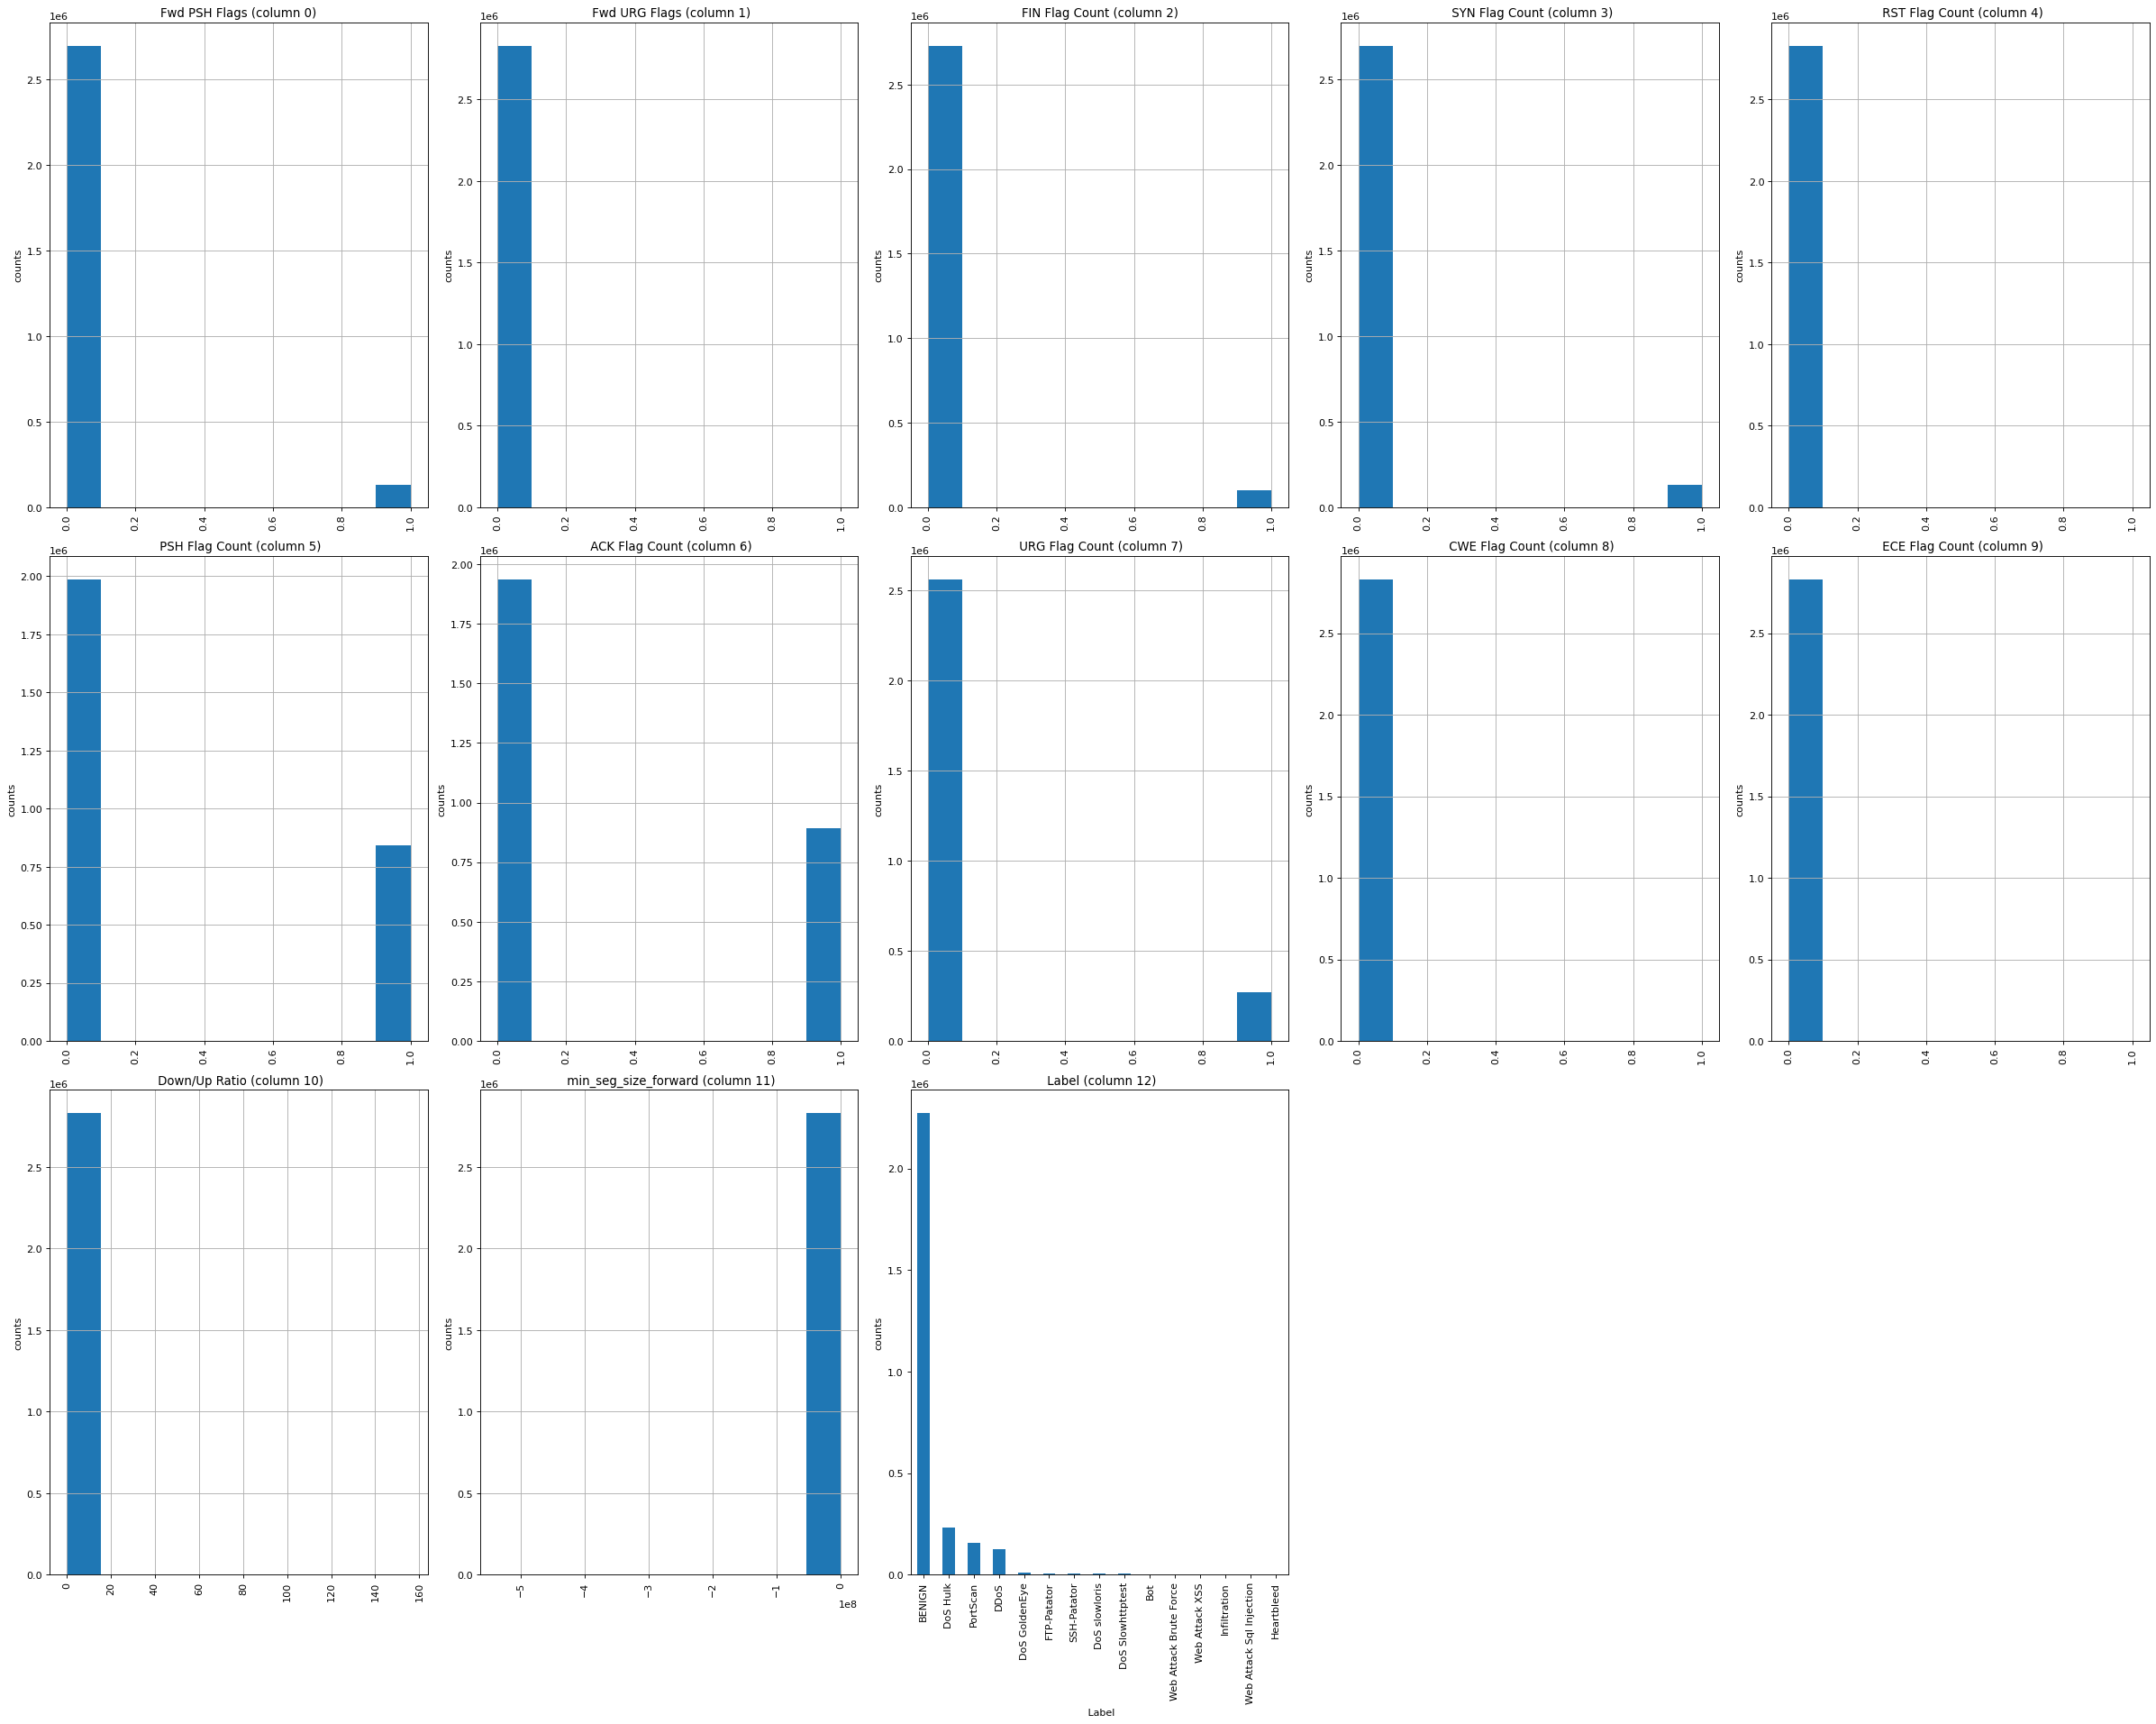

In [5]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]  # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int(np.ceil(nCol / nGraphPerRow))  # Ensure the number of rows is a positive integer
    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(type(columnDf.iloc[0]), np.number):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

plotPerColumnDistribution(df, 79, 5)


In [6]:
#Split dataset on train and test
train, test=train_test_split(df,test_size=0.3, random_state=10)

train.describe()
test.describe()

# Packet Attack Distribution
train[' Label'].value_counts()
test[' Label'].value_counts()

 Label
BENIGN                      682092
DoS Hulk                     69066
PortScan                     47841
DDoS                         38346
DoS GoldenEye                 3041
FTP-Patator                   2359
SSH-Patator                   1786
DoS slowloris                 1764
DoS Slowhttptest              1649
Bot                            580
Web Attack Brute Force         465
Web Attack XSS                 203
Infiltration                    21
Web Attack Sql Injection         8
Heartbleed                       2
Name: count, dtype: int64

In [7]:
# Separate target variable from features
train_X = train.drop(' Label', axis=1)
test_X = test.drop(' Label', axis=1)
train_y = train[' Label']
test_y = test[' Label']


In [8]:
# Replace infinite values with NaN
train_X.replace([np.inf, -np.inf], np.nan, inplace=True)
test_X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [9]:
# Reset index
train_X.reset_index(drop=True, inplace=True)
test_X.reset_index(drop=True, inplace=True)


In [10]:
# Scalling numerical attributes
scaler = StandardScaler()
cols = train_X.select_dtypes(include=['float64', 'int64']).columns


In [11]:
# Check for extremely large values and replace with NaN
train_X[(train_X > 1e308) | (train_X < -1e308)] = np.nan
test_X[(test_X > 1e308) | (test_X < -1e308)] = np.nan

In [12]:
# Handle NaN values for features
imputer = SimpleImputer(strategy='mean')
train_X = pd.DataFrame(imputer.fit_transform(train_X), columns=train_X.columns)
test_X = pd.DataFrame(imputer.transform(test_X), columns=test_X.columns)

In [13]:
# Standard scaling
sc_train_X = scaler.fit_transform(train_X.select_dtypes(include=['float64', 'int64']))
sc_test_X = scaler.transform(test_X.select_dtypes(include=['float64', 'int64']))

In [14]:
# Turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train_X, columns=cols)
sc_testdf = pd.DataFrame(sc_test_X, columns=cols)

In [15]:
# Reset index for train_y and test_y
train_y.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)

In [16]:
# Concatenate target variable back with reset index
train_df = pd.concat([sc_traindf, train_y], axis=1)
test_df = pd.concat([sc_testdf, test_y], axis=1)


In [17]:
# One-hot encode labels for supervised learning
onehotencoder = OneHotEncoder()
trainDep = train_df[' Label'].values.reshape(-1, 1)
trainDep = onehotencoder.fit_transform(trainDep).toarray()
testDep = test_df[' Label'].values.reshape(-1, 1)
testDep = onehotencoder.transform(testDep).toarray()
train_X = sc_traindf
train_y = trainDep[:, 0]
test_X = sc_testdf
test_y = testDep[:, 0]

In [23]:
# Train supervised machine learning Logistic Regression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(train_X, train_y)


LogisticRegression(n_jobs=-1, random_state=0)

In [26]:
# Training supervised machine learning Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(train_X, train_y)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [27]:
# Training supervised machine learning AdaBoost Model
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(train_X, train_y)


AdaBoostClassifier()

In [28]:
# Training unsupervised machine learning Isolation Forest Model
isolation_forest_classifier = IsolationForest()
isolation_forest_classifier.fit(train_X)


IsolationForest()

In [29]:
# Logistic Regression Classifier Evaluation
predictions_lgr = LGR_Classifier.predict(test_X)
accuracy_lgr = metrics.accuracy_score(test_y, predictions_lgr)
precision_lgr = metrics.precision_score(test_y, predictions_lgr)
recall_lgr = metrics.recall_score(test_y, predictions_lgr)
f1_score_lgr = metrics.f1_score(test_y, predictions_lgr)
confusion_matrix_lgr = metrics.confusion_matrix(test_y, predictions_lgr)

# Save Logistic Regression Classifier Model
joblib.dump(LGR_Classifier, 'logistic_regression_classifier_model.pkl')


['logistic_regression_classifier_model.pkl']

In [30]:
# Print Evaluation Metrics for Logistic Regression Classifier
print("============================== Logistic Regression Classifier Model Evaluation ==============================")
print("\nModel Accuracy:", accuracy_lgr)
print("\nPrecision:", precision_lgr)
print("\nRecall:", recall_lgr)
print("\nF1 Score:", f1_score_lgr)
print("\nConfusion Matrix:\n", confusion_matrix_lgr)

============================== Logistic Regression Classifier Model Evaluation ==============================

Model Accuracy: 0.939651893554461

Precision: 0.9602805272581613

Recall: 0.9647701483084393

F1 Score: 0.9625201024153615

Confusion Matrix:
 [[139912  27219]
 [ 24030 658062]]


In [31]:
# Decision Tree Classifier Evaluation
predictions_dt = DTC_Classifier.predict(test_X)
accuracy_dt = metrics.accuracy_score(test_y, predictions_dt)
precision_dt = metrics.precision_score(test_y, predictions_dt)
recall_dt = metrics.recall_score(test_y, predictions_dt)
f1_score_dt = metrics.f1_score(test_y, predictions_dt)
confusion_matrix_dt = metrics.confusion_matrix(test_y, predictions_dt)
# Save Decision Tree Classifier Model
joblib.dump(DTC_Classifier, 'decision_tree_classifier_model.pkl')

['decision_tree_classifier_model.pkl']

In [32]:
# Print Evaluation Metrics
print("============================== Decision Tree Classifier Model Evaluation ==============================")
print("\nModel Accuracy:", accuracy_dt)
print("\nPrecision:", precision_dt)
print("\nRecall:", recall_dt)
print("\nF1 Score:", f1_score_dt)
print("\nConfusion Matrix:\n", confusion_matrix_dt)

============================== Decision Tree Classifier Model Evaluation ==============================

Model Accuracy: 0.9988295182772958

Precision: 0.9993958253289966

Recall: 0.9991467426681445

F1 Score: 0.9992712684767165

Confusion Matrix:
 [[166719    412]
 [   582 681510]]


In [33]:
# AdaBoost Classifier Evaluation
predictions_ab = adaboost_classifier.predict(test_X)
accuracy_ab = metrics.accuracy_score(test_y, predictions_ab)
precision_ab = metrics.precision_score(test_y, predictions_ab)
recall_ab = metrics.recall_score(test_y, predictions_ab)
f1_score_ab = metrics.f1_score(test_y, predictions_ab)
confusion_matrix_ab = metrics.confusion_matrix(test_y, predictions_ab)

# Save AdaBoost Classifier Model
joblib.dump(adaboost_classifier, 'adaboost_classifier_model.pkl')

['adaboost_classifier_model.pkl']

In [34]:
# Print Evaluation Metrics for AdaBoost Classifier
print("============================== AdaBoost Classifier Model Evaluation ==============================")
print("\nModel Accuracy:", accuracy_ab)
print("\nPrecision:", precision_ab)
print("\nRecall:", recall_ab)
print("\nF1 Score:", f1_score_ab)
print("\nConfusion Matrix:\n", confusion_matrix_ab)

============================== AdaBoost Classifier Model Evaluation ==============================

Model Accuracy: 0.9925213989729434

Precision: 0.995506468251233

Recall: 0.995181001976273

F1 Score: 0.9953437085077945

Confusion Matrix:
 [[164067   3064]
 [  3287 678805]]


In [35]:
# Isolation Forest Classifier Evaluation
predictions_if = isolation_forest_classifier.predict(test_X)
predictions_if[predictions_if == 1] = 0  # Convert normal instances to 0, and anomalies to 1
predictions_if[predictions_if == -1] = 1
accuracy_if = metrics.accuracy_score(test_y, predictions_if)
precision_if = metrics.precision_score(test_y, predictions_if)
recall_if = metrics.recall_score(test_y, predictions_if)
f1_score_if = metrics.f1_score(test_y, predictions_if)
confusion_matrix_if = metrics.confusion_matrix(test_y, predictions_if)

# Save Isolation Forest Classifier Model
joblib.dump(isolation_forest_classifier, 'isolation_forest_classifier_model.pkl')


['isolation_forest_classifier_model.pkl']

In [36]:
# Print Evaluation Metrics for Isolation Forest Classifier
print("============================== Isolation Forest Classifier Model Evaluation ==============================")
print("\nModel Accuracy:", accuracy_if)
print("\nPrecision:", precision_if)
print("\nRecall:", recall_if)
print("\nF1 Score:", f1_score_if)
print("\nConfusion Matrix:\n", confusion_matrix_if)

============================== Isolation Forest Classifier Model Evaluation ==============================

Model Accuracy: 0.20512986577141692

Precision: 0.5393083509396197

Recall: 0.07110477765462724

F1 Score: 0.1256440878627811

Confusion Matrix:
 [[125701  41430]
 [633592  48500]]


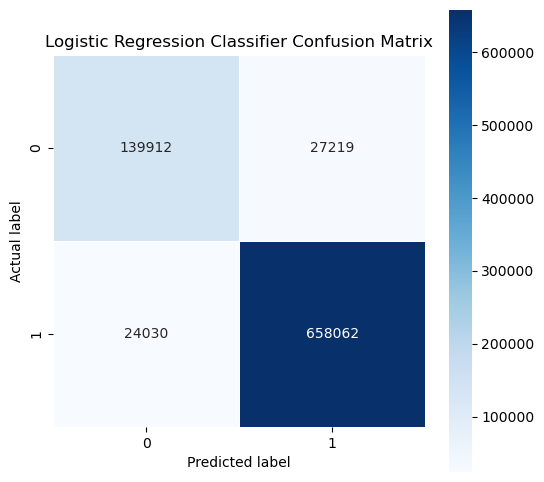

In [38]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, square=True)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.show()

# Plot Confusion Matrix for Logistic Regression Classifier
plot_confusion_matrix(confusion_matrix_lgr, 'Logistic Regression Classifier Confusion Matrix')



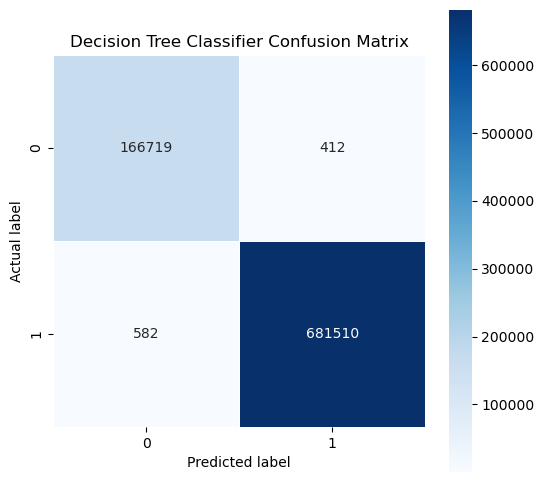

In [39]:
# Plot Confusion Matrix for Decision Tree Classifier
plot_confusion_matrix(confusion_matrix_dt, 'Decision Tree Classifier Confusion Matrix')

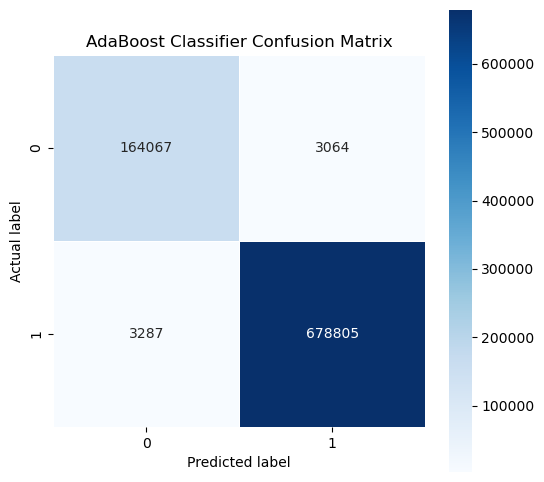

In [40]:
# Plot Confusion Matrix for AdaBoost Classifier
plot_confusion_matrix(confusion_matrix_ab, 'AdaBoost Classifier Confusion Matrix')


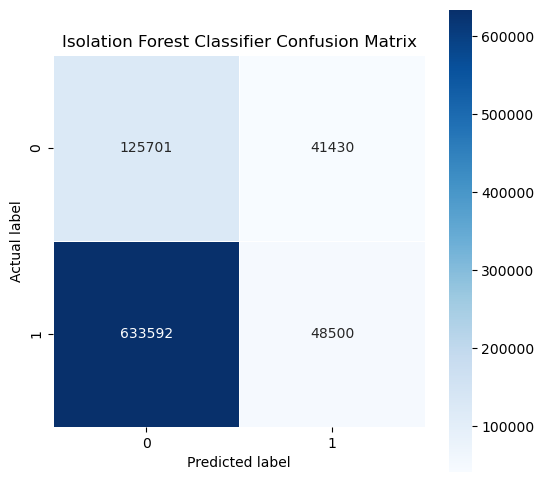

In [41]:
# Plot Confusion Matrix for Isolation Forest Classifier
plot_confusion_matrix(confusion_matrix_if, 'Isolation Forest Classifier Confusion Matrix')

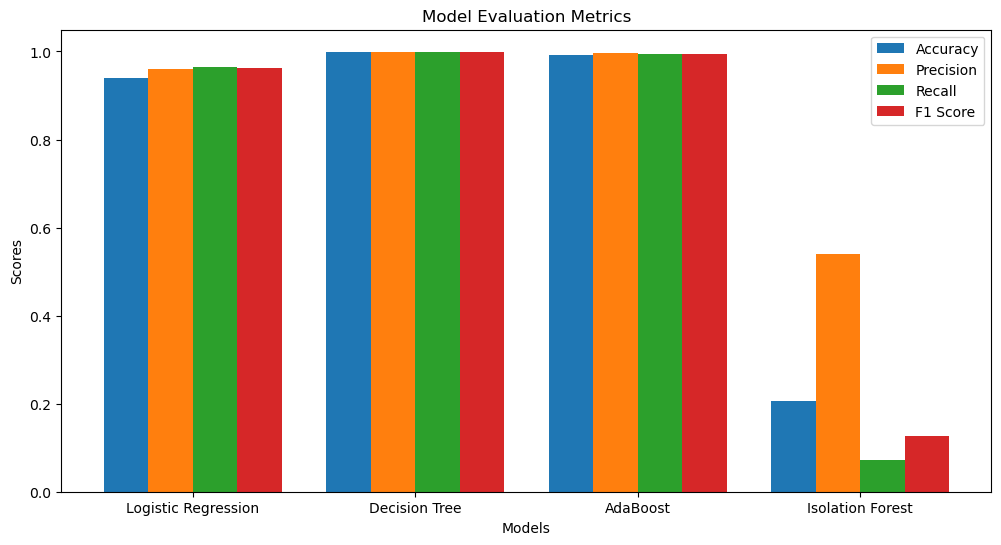

In [42]:
# Plotting Accuracy, Precision, Recal and F1 Score

models = ['Logistic Regression', 'Decision Tree', 'AdaBoost', 'Isolation Forest']
accuracy_scores = [accuracy_lgr, accuracy_dt, accuracy_ab, accuracy_if]
precision_scores = [precision_lgr, precision_dt, precision_ab, precision_if]
recall_scores = [recall_lgr, recall_dt, recall_ab, recall_if]
f1_scores = [f1_score_lgr, f1_score_dt, f1_score_ab, f1_score_if]

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.2
index = np.arange(len(models))

bar1 = ax.bar(index, accuracy_scores, bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, precision_scores, bar_width, label='Precision')
bar3 = ax.bar(index + 2 * bar_width, recall_scores, bar_width, label='Recall')
bar4 = ax.bar(index + 3 * bar_width, f1_scores, bar_width, label='F1 Score')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(models)
ax.legend()

plt.show()
